# Biomass Estimation - Putting the RAT into TPOT  
<img src='http://www.auscover.org.au/wp-content/themes/auscover/assets/images/logo.png'>


#### A demonstration on linking field data to image data using machine learning
_DISCLAIMER: This is only a demonstration of some cool data science methods you can pull off on your laptop at home, and not about the science of Biomass estimation. There are some very good scientists and programs looking at how to improve biomass estimation and better quantify the error budget. Whatever comes out of the bottom of this worksheet is to be used for your amusement only :)_


_By [Peter Scarth](mailto:p.scarth@uq.edu.au?subject=AEOCCG%20webinar%20information) (Joint Remote Sensing Research Program) _

### Abstract

This is a quick and dirty notebook demonstrating how to link two data sets I pulled off the [AusCover](http://auscover.org.au) portal. In particular, I wanted to show how powerful the combination of Raster Attribute Tables (RATs) and Machine Learning (ML) is for getting quick insights into data at a national scale.  I pulled this together one Sunday night so it's not necessarily pretty or efficient but it might give someone else a heads up into getting started with integrated ecological data science using [TERN](http://www.tern.org.au/) data.

This uses a number of awesome python libraries. I'd really recommend [conda](https://conda.io/) to get going, or if you like Docker pull my [datascience-rs](https://hub.docker.com/r/petescarth/datascience-rs/) container that has everything you need to run this installed.


#### Raster Attribute Tables
For an excellent introduction to RATs I recommend the following paper:

Clewley, D.; Bunting, P.; Shepherd, J.; Gillingham, S.; Flood, N.; Dymond, J.; Lucas, R.; Armston, J.; Moghaddam, M. _A Python-Based Open Source System for Geographic Object-Based Image Analysis (GEOBIA) Utilizing Raster Attribute Tables_. [__Remote Sensing 2014, 6, 6111-6135__](http://www.mdpi.com/2072-4292/6/7/6111). 

RATs work well with machine learning and quick data analysis. To run the prediction across the continent using this notebook takes about __30 minutes__ (depends on the final model) when working on the RAT. It would take around 6000x longer or nearly __18 weeks__ to process the image on a per-pixel basis.

If you want a lightweight raster GIS with powerful RAT manipulation abilities have a look at [Tuiview](http://tuiview.org/)

#### Machine Learning
I really like [TPOT](http://rhiever.github.io/tpot/) for this sort of analysis. It's close to magical for me. You can possibly do better through careful ML pipeline selection and tuning but it really helps to get you started.
_"Consider TPOT your Data Science Assistant. TPOT is a Python tool that automatically creates and optimizes machine learning pipelines using genetic programming."_

#### Biomass Library
The [Biomass Plot Library](http://www.auscover.org.au/purl/biomass-plot-library) is  a national collation of tree and shrub inventory data, allometric model predictions of above and below-ground biomass for Australia. More data is being added all the time.

The data in this notebook was extracted using the [Field Data Portal](http://qld.auscover.org.au/public/html/field/). I selected the __Biomass__ Library and then the __Site Level__ Dataset.  I downloaded the whole lot as a csv file and that file (`biolib_sitelist_auscover.csv`) is what I use here.

<img src='http://www.auscover.org.au/wp-content/uploads/biomass-plot-library.jpg' >

#### Height and Structure Data
The [Vegetation height and structure - derived from ALOS-1 PALSAR, Landsat and ICESat/GLAS, Australia](http://auscover.org.au/purl/icesat-vegetation-structure  ) contains vertical plant profiles for the Australian continent derived through integration of ICESat GLAS waveforms with ALOS PALSAR and Landsat data products. 

There are individual tiff files of the various parameters available for download, but you're going to want the  [KEA](http://www.gdal.org/frmt_kea.html) file of all the parameters and the segments (`alpsbk_aust_y2009_sc5a2.kea`) which is available [here](http://qld.auscover.org.au/public/data/spatial_other/jrsrp/height/alpsbk_aust_y2009_sc5a2.kea) as a __9.1 G__ download.  I'm yet to work out how to efficiently access kea files over the internet, like we do using the /vsicurl/ driver for GeoTIFF, so for now you'll need to download it.


<img src='http://www.auscover.org.au/wp-content/uploads/Vegetation-height-and-structure.jpg' >

In [1]:
# Imports for this Python3 notebook
import numpy
import matplotlib.pyplot as plt

from osgeo import gdal
from osgeo import ogr
from osgeo import osr

from rios import rat
from rios import ratapplier

from tpot import TPOTRegressor


## Prepare the training data
This section reads in the Biomass library csv file and links the observations to the closest segment.  
NOTE: _No consideration is made of the size or shape of the field plot or the shapes of the segments!_

The Biomass Library has the following fields:
`longitude,latitude,live_basal_area_ha,dead_basal_area_ha,live_tree_density_ha,dead_tree_density_ha,
agb_drymass_ha,agb_drymass_se_ha,bgb_drymass_ha,bgb_drymass_se_ha,tb_drymass_ha,tb_drymass_se_ha`  

Once we find the closest segment, we extract the attributes we want from the RAT to aget an _imageData_ array to match with the _fieldBiomass_ array.


In [2]:
# Read Biomass library data from the csv file 
fieldBiomass=numpy.loadtxt("biolib_sitelist_auscover.csv",delimiter=',', skiprows=1)

# Open Height Map dataset
keaFile = "alpsbk_aust_y2009_sc5a2.kea"

heightDataset = gdal.Open(keaFile, gdal.GA_Update)


# Set up the reprojection transform from WGS84 (biomass library) to Australian Albers (height data)
source = osr.SpatialReference()
source.ImportFromEPSG(4326)
target = osr.SpatialReference()
target.ImportFromEPSG(3577)
transform = osr.CoordinateTransformation(source, target)


# Open the raster band with the segment IDs
heightBand=heightDataset.GetRasterBand(1)

# Get the Albers to pixel transform
geoTransform=heightDataset.GetGeoTransform()

# Find the segmentID for all the field sites
print("Linking field observations to segment IDs\n")
segmentIDs = []
for record in fieldBiomass:
    # Make up a site OGR point
    site = ogr.Geometry(ogr.wkbPoint)
    site.AddPoint(record[0], record[1])
    # Transform the site to EPSG3577
    site.Transform(transform)
    # Get the pixel location of the site
    mx,my=site.GetX(), site.GetY()  #coord in map units
    #Convert from map to pixel coordinates.
    #Only works for geotransforms with no rotation.
    px = int((mx - geoTransform[0]) / geoTransform[1]) #x pixel
    py = int((my - geoTransform[3]) / geoTransform[5]) #y pixel
    # Extract the segmentID for the location
    segmentIDs.append(heightBand.ReadAsArray(px,py,1,1)[0][0])

# Get the RAT column names
colNames = rat.getColumnNames(heightDataset)

# Select the columns used for the training/prediction
trainingColumns = [5,6,7,8,9,10,15,19,22,23,25,26,27,28,29,30,31,32,33,34]
trainingNames = [colNames[i] for i in trainingColumns]

# Now we have the segmentIDs, pull the image data from the RAT that corresponds to the segment IDs
imageData = []
# Iterate for all the RAT columns
for name in trainingNames:
    print("Extracting sites from " + name)
    # Extract the array of values corresponding to the field site segments
    imageData.append(rat.readColumnFromBand(heightBand,name).astype('float')[segmentIDs])

# Convert the list of arrays to an array
imageData = numpy.transpose(numpy.array(imageData))

# Remove nodata from the couple of segments too small to get statistics in the image data
goodDataIDX = imageData.min(axis=1)>0
imageData = imageData[goodDataIDX]
fieldBiomass = fieldBiomass[goodDataIDX]


print("\nTraining data has %d observations and %d columns" % imageData.shape)

Linking field observations to segment IDs

Extracting sites from PGmean
Extracting sites from PGsd
Extracting sites from HHmean
Extracting sites from HHsd
Extracting sites from HVmean
Extracting sites from HVsd
Extracting sites from rhogc1000
Extracting sites from fcovc1000
Extracting sites from rhovc1000
Extracting sites from gSDc1000
Extracting sites from fcov_10_30c1000
Extracting sites from fcov_totalc1000
Extracting sites from fcov_30plusc1000
Extracting sites from fcov_0_5c1000
Extracting sites from fcov_5_10c1000
Extracting sites from hp50c1000satcor
Extracting sites from hp75c1000satcor
Extracting sites from hp95c1000satcor
Extracting sites from hp25c1000satcor
Extracting sites from hModec1000satcor

Training data has 14373 observations and 20 columns


## Build the Machine Learning Model
This uses the amazing [TPOT](https://github.com/rhiever/tpot) tool to find a good machine learning pipeline that predicts biomass. It automates the most tedious part of machine learning by intelligently exploring thousands of possible pipelines to find the best one for your data. There are a few setting below to tweak.  
  - _optTime_ is the number of minutes you are prepared to wait for the optimisation. The longer the better.
  - _nCPUs_ is the number of CPUs you have available for the search. You'll also need a minimum of about 2GB of RAM per CPU
  - _Scoring_ is the thing you'll be minimising
  - _nSubsets_ picks a random subset from the training data. Smaller is faster but you might miss some variation in the data
  - The field from the biomass library you want to fit. Here we're selecting the __Total Biomass__ column (number 10)

This will run a genetic algorithm until it times out and selects the best fitting model to use for biomass prediction. It saves the model so you can play with it later if you want.

Version 0.7.0 of tpot is outdated. Version 0.7.3 was released 3 days ago.


Optimization Progress: 100%|██████████| 200/200 [32:53<00:00, 12.87s/pipeline]

Generation 1 - Current best internal CV score: 229910.137252398


Optimization Progress: 100%|██████████| 300/300 [38:25<00:00,  4.52s/pipeline]

Generation 2 - Current best internal CV score: 229910.137252398


Optimization Progress: 100%|██████████| 400/400 [40:41<00:00,  1.52s/pipeline]

Generation 3 - Current best internal CV score: 228267.0934472912


Optimization Progress: 100%|██████████| 500/500 [43:17<00:00,  2.00s/pipeline]

Generation 4 - Current best internal CV score: 228267.0934472912


Optimization Progress: 100%|██████████| 600/600 [45:51<00:00,  5.31s/pipeline]

Generation 5 - Current best internal CV score: 228267.0934472912


Optimization Progress: 100%|██████████| 700/700 [48:06<00:00,  2.39s/pipeline]

Generation 6 - Current best internal CV score: 228267.0934472912


Optimization Progress: 100%|██████████| 800/800 [50:10<00:00,  1.73s/pipeline]

Generation 7 - Current best internal CV score: 228267.0934472912


Optimization Progress: 100%|██████████| 900/900 [51:01<00:00,  1.18pipeline/s]

Generation 8 - Current best internal CV score: 228267.0934472912


Optimization Progress: 100%|██████████| 1000/1000 [51:20<00:00,  2.42pipeline/s]

Generation 9 - Current best internal CV score: 226855.2013595368


Optimization Progress: 100%|██████████| 1100/1100 [52:28<00:00,  1.41s/pipeline]

Generation 10 - Current best internal CV score: 226855.2013595368


Optimization Progress: 100%|██████████| 1200/1200 [53:15<00:00,  1.18s/pipeline]

Generation 11 - Current best internal CV score: 226855.2013595368


Optimization Progress: 100%|██████████| 1300/1300 [54:07<00:00,  1.19s/pipeline]

Generation 12 - Current best internal CV score: 226813.9850626458


Optimization Progress: 100%|██████████| 1400/1400 [55:07<00:00,  1.07pipeline/s]

Generation 13 - Current best internal CV score: 226813.9850626458


Optimization Progress: 100%|██████████| 1500/1500 [55:49<00:00,  1.02s/pipeline]

Generation 14 - Current best internal CV score: 226813.9850626458


Optimization Progress: 100%|██████████| 1600/1600 [59:51<00:00,  2.95s/pipeline]

Generation 15 - Current best internal CV score: 226813.9850626458


Optimization Progress: 100%|██████████| 1700/1700 [1:00:43<00:00,  1.19s/pipeline]

Generation 16 - Current best internal CV score: 226774.39524670615


Optimization Progress: 100%|██████████| 1800/1800 [1:01:07<00:00,  1.29pipeline/s]

Generation 17 - Current best internal CV score: 226774.39524670615


Optimization Progress: 100%|██████████| 1900/1900 [1:01:44<00:00,  1.13s/pipeline]

Generation 18 - Current best internal CV score: 225972.42834176874


Optimization Progress: 100%|██████████| 2000/2000 [1:02:24<00:00,  1.52s/pipeline]

Generation 19 - Current best internal CV score: 225972.42834176874


Optimization Progress: 100%|██████████| 2100/2100 [1:03:08<00:00,  1.13s/pipeline]

Generation 20 - Current best internal CV score: 225972.42834176874


Optimization Progress: 100%|██████████| 2200/2200 [1:04:00<00:00,  1.10s/pipeline]

Generation 21 - Current best internal CV score: 225972.42834176874


Optimization Progress: 100%|██████████| 2300/2300 [1:04:56<00:00,  1.84s/pipeline]

Generation 22 - Current best internal CV score: 225972.42834176874


Optimization Progress: 100%|██████████| 2400/2400 [1:06:05<00:00,  1.66s/pipeline]

Generation 23 - Current best internal CV score: 225972.42834176874


Optimization Progress: 100%|██████████| 2500/2500 [1:06:53<00:00,  1.29pipeline/s]

Generation 24 - Current best internal CV score: 225972.42834176874


Optimization Progress: 100%|██████████| 2600/2600 [1:07:40<00:00,  3.75s/pipeline]

Generation 25 - Current best internal CV score: 225972.42834176874


Optimization Progress: 100%|██████████| 2700/2700 [1:08:23<00:00,  1.24pipeline/s]

Generation 26 - Current best internal CV score: 225972.42834176874


Optimization Progress: 100%|██████████| 2800/2800 [1:09:22<00:00,  1.64s/pipeline]

Generation 27 - Current best internal CV score: 225972.42834176874


Optimization Progress: 100%|██████████| 2900/2900 [1:09:51<00:00,  1.15pipeline/s]

Generation 28 - Current best internal CV score: 225972.42834176874


Optimization Progress: 100%|██████████| 3000/3000 [1:10:43<00:00,  1.30s/pipeline]

Generation 29 - Current best internal CV score: 225972.42834176874


Optimization Progress: 100%|██████████| 3100/3100 [1:11:53<00:00,  1.72s/pipeline]

Generation 30 - Current best internal CV score: 225972.42834176874


Optimization Progress: 100%|██████████| 3200/3200 [1:12:42<00:00,  1.37s/pipeline]

Generation 31 - Current best internal CV score: 225972.42834176874


Optimization Progress: 100%|██████████| 3300/3300 [1:13:45<00:00,  1.10s/pipeline]

Generation 32 - Current best internal CV score: 225972.42834176874


Optimization Progress: 100%|██████████| 3400/3400 [1:14:38<00:00,  1.42s/pipeline]

Generation 33 - Current best internal CV score: 225972.42834176874


Optimization Progress: 100%|██████████| 3500/3500 [1:15:43<00:00,  1.66s/pipeline]

Generation 34 - Current best internal CV score: 225972.42834176874


Optimization Progress: 100%|██████████| 3600/3600 [1:16:49<00:00,  3.60s/pipeline]

Generation 35 - Current best internal CV score: 225972.42834176874


Optimization Progress: 100%|██████████| 3700/3700 [1:17:55<00:00,  2.12s/pipeline]

Generation 36 - Current best internal CV score: 225972.42834176874


Optimization Progress: 100%|██████████| 3800/3800 [1:18:43<00:00,  1.44s/pipeline]

Generation 37 - Current best internal CV score: 225972.42834176874


Optimization Progress: 100%|██████████| 3900/3900 [1:19:32<00:00,  2.97s/pipeline]

Generation 38 - Current best internal CV score: 225972.42834176874


Optimization Progress: 100%|██████████| 4000/4000 [1:20:37<00:00,  4.07s/pipeline]

Generation 39 - Current best internal CV score: 225972.42834176874


Optimization Progress: 100%|██████████| 4100/4100 [1:21:07<00:00,  1.95s/pipeline]

Generation 40 - Current best internal CV score: 225972.42834176874


Optimization Progress: 100%|██████████| 4200/4200 [1:21:58<00:00,  1.78s/pipeline]

Generation 41 - Current best internal CV score: 225972.42834176874


Optimization Progress: 100%|██████████| 4300/4300 [1:22:48<00:00,  7.46s/pipeline]

Generation 42 - Current best internal CV score: 225972.42834176874


Optimization Progress: 100%|██████████| 4400/4400 [1:23:18<00:00,  1.80s/pipeline]

Generation 43 - Current best internal CV score: 225972.42834176874


Optimization Progress: 100%|██████████| 4500/4500 [1:24:08<00:00,  2.00s/pipeline]

Generation 44 - Current best internal CV score: 225972.42834176874


Optimization Progress: 100%|██████████| 4600/4600 [1:24:55<00:00,  1.48s/pipeline]

Generation 45 - Current best internal CV score: 225972.42834176874


Optimization Progress: 100%|██████████| 4700/4700 [1:25:44<00:00,  1.22s/pipeline]

Generation 46 - Current best internal CV score: 225972.42834176874


Optimization Progress: 100%|██████████| 4800/4800 [1:26:49<00:00,  5.95s/pipeline]

Generation 47 - Current best internal CV score: 225972.42834176874


Optimization Progress: 100%|██████████| 4900/4900 [1:27:31<00:00,  2.36s/pipeline]

Generation 48 - Current best internal CV score: 225972.42834176874


Optimization Progress: 100%|██████████| 5000/5000 [1:28:35<00:00,  3.67s/pipeline]

Generation 49 - Current best internal CV score: 225972.42834176874


Optimization Progress: 100%|██████████| 5100/5100 [1:29:25<00:00,  3.12s/pipeline]

Generation 50 - Current best internal CV score: 225972.42834176874


Optimization Progress: 100%|██████████| 5200/5200 [1:29:57<00:00,  1.23s/pipeline]

Generation 51 - Current best internal CV score: 225972.42834176874


Optimization Progress: 100%|██████████| 5300/5300 [1:30:50<00:00,  2.31s/pipeline]

Generation 52 - Current best internal CV score: 225972.42834176874


Optimization Progress: 100%|██████████| 5400/5400 [1:31:37<00:00,  1.85s/pipeline]

Generation 53 - Current best internal CV score: 225972.42834176874


Optimization Progress: 100%|██████████| 5500/5500 [1:32:35<00:00,  7.12s/pipeline]

Generation 54 - Current best internal CV score: 225972.42834176874


Optimization Progress: 100%|██████████| 5600/5600 [1:33:05<00:00,  1.64s/pipeline]

Generation 55 - Current best internal CV score: 225972.42834176874


Optimization Progress: 100%|██████████| 5700/5700 [1:33:49<00:00,  1.61s/pipeline]

Generation 56 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 5800/5800 [1:34:42<00:00,  1.79s/pipeline]

Generation 57 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 5900/5900 [1:35:56<00:00,  3.07s/pipeline]

Generation 58 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 6000/6000 [1:36:31<00:00,  2.04s/pipeline]

Generation 59 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 6100/6100 [1:37:03<00:00,  1.97s/pipeline]

Generation 60 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 6200/6200 [1:37:49<00:00,  3.29s/pipeline]

Generation 61 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 6300/6300 [1:38:28<00:00,  2.65s/pipeline]

Generation 62 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 6400/6400 [1:39:18<00:00,  2.67s/pipeline]

Generation 63 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 6500/6500 [1:40:01<00:00,  3.37s/pipeline]

Generation 64 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 6600/6600 [1:40:42<00:00,  2.22s/pipeline]

Generation 65 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 6700/6700 [1:41:23<00:00,  1.30s/pipeline]

Generation 66 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 6800/6800 [1:42:06<00:00,  3.57s/pipeline]

Generation 67 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 6900/6900 [1:43:18<00:00,  7.15s/pipeline]

Generation 68 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 7000/7000 [1:43:48<00:00,  2.67s/pipeline]

Generation 69 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 7100/7100 [1:44:14<00:00,  2.01s/pipeline]

Generation 70 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 7200/7200 [1:45:13<00:00,  2.08s/pipeline]

Generation 71 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 7300/7300 [1:45:32<00:00,  1.13s/pipeline]

Generation 72 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 7400/7400 [1:46:07<00:00,  2.81s/pipeline]

Generation 73 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 7500/7500 [1:46:57<00:00,  2.56s/pipeline]

Generation 74 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 7600/7600 [1:47:46<00:00,  2.21s/pipeline]

Generation 75 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 7700/7700 [1:48:41<00:00,  2.98s/pipeline]

Generation 76 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 7800/7800 [1:49:19<00:00,  2.44s/pipeline]

Generation 77 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 7900/7900 [1:50:22<00:00,  5.68s/pipeline]

Generation 78 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 8000/8000 [1:51:10<00:00,  5.59s/pipeline]

Generation 79 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 8100/8100 [1:52:15<00:00,  5.92s/pipeline]

Generation 80 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 8200/8200 [1:52:39<00:00,  1.89s/pipeline]

Generation 81 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 8300/8300 [1:53:27<00:00,  3.61s/pipeline]

Generation 82 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 8400/8400 [1:53:55<00:00,  1.66s/pipeline]

Generation 83 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 8500/8500 [1:54:41<00:00,  3.75s/pipeline]

Generation 84 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 8600/8600 [1:55:34<00:00,  5.19s/pipeline]

Generation 85 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 8700/8700 [1:56:22<00:00,  2.72s/pipeline]

Generation 86 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 8800/8800 [1:56:54<00:00,  1.68s/pipeline]

Generation 87 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 8900/8900 [2:01:09<00:00,  9.46s/pipeline]

Generation 88 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 9000/9000 [2:01:34<00:00,  2.38s/pipeline]

Generation 89 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 9100/9100 [2:02:14<00:00,  1.90s/pipeline]

Generation 90 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 9200/9200 [2:02:51<00:00,  2.59s/pipeline]

Generation 91 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 9300/9300 [2:03:11<00:00,  1.22s/pipeline]

Generation 92 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 9400/9400 [2:03:45<00:00,  4.21s/pipeline]

Generation 93 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 9500/9500 [2:05:00<00:00,  4.65s/pipeline]

Generation 94 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 9600/9600 [2:05:59<00:00,  1.57s/pipeline]

Generation 95 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 9700/9700 [2:06:45<00:00,  2.88s/pipeline]

Generation 96 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 9800/9800 [2:07:13<00:00,  1.58s/pipeline]

Generation 97 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 9900/9900 [2:07:49<00:00,  2.46s/pipeline]

Generation 98 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 10000/10000 [2:08:37<00:00,  2.15s/pipeline]

Generation 99 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 10100/10100 [2:09:00<00:00,  2.83s/pipeline]

Generation 100 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 10200/10200 [2:09:44<00:00,  2.49s/pipeline]

Generation 101 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 10300/10300 [2:10:28<00:00,  1.40s/pipeline]

Generation 102 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 10400/10400 [2:10:57<00:00,  4.19s/pipeline]

Generation 103 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 10500/10500 [2:11:27<00:00,  1.67s/pipeline]

Generation 104 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 10600/10600 [2:12:16<00:00,  1.19s/pipeline]

Generation 105 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 10700/10700 [2:12:38<00:00,  1.47pipeline/s]

Generation 106 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 10800/10800 [2:13:53<00:00,  2.12s/pipeline]

Generation 107 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 10900/10900 [2:14:50<00:00,  1.58s/pipeline]

Generation 108 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 11000/11000 [2:15:24<00:00,  1.74s/pipeline]

Generation 109 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 11100/11100 [2:15:59<00:00,  4.60s/pipeline]

Generation 110 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 11200/11200 [2:19:34<00:00,  8.91s/pipeline]

Generation 111 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 11300/11300 [2:20:33<00:00,  7.17s/pipeline]

Generation 112 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 11400/11400 [2:21:01<00:00,  2.17s/pipeline]

Generation 113 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 11500/11500 [2:21:45<00:00,  5.39s/pipeline]

Generation 114 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 11600/11600 [2:22:30<00:00,  5.37s/pipeline]

Generation 115 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 11700/11700 [2:23:19<00:00,  3.86s/pipeline]

Generation 116 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 11800/11800 [2:23:38<00:00,  4.78s/pipeline]

Generation 117 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 11900/11900 [2:24:28<00:00,  5.02s/pipeline]

Generation 118 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 12000/12000 [2:25:00<00:00,  1.74s/pipeline]

Generation 119 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 12100/12100 [2:25:47<00:00,  2.86s/pipeline]

Generation 120 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 12200/12200 [2:26:14<00:00,  1.47s/pipeline]

Generation 121 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 12300/12300 [2:26:59<00:00,  1.81s/pipeline]

Generation 122 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 12400/12400 [2:27:25<00:00,  2.01s/pipeline]

Generation 123 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 12500/12500 [2:28:05<00:00,  3.46s/pipeline]

Generation 124 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 12600/12600 [2:28:42<00:00,  1.83s/pipeline]

Generation 125 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 12700/12700 [2:29:25<00:00,  1.42s/pipeline]

Generation 126 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 12800/12800 [2:30:21<00:00,  2.09s/pipeline]

Generation 127 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 12900/12900 [2:31:02<00:00,  2.64s/pipeline]

Generation 128 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 13000/13000 [2:31:42<00:00,  2.46s/pipeline]

Generation 129 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 13100/13100 [2:32:08<00:00,  1.63s/pipeline]

Generation 130 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 13200/13200 [2:32:55<00:00,  2.27s/pipeline]

Generation 131 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 13300/13300 [2:36:24<00:00,  9.27s/pipeline]

Generation 132 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 13400/13400 [2:37:16<00:00,  3.64s/pipeline]

Generation 133 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 13500/13500 [2:37:23<00:00,  1.08pipeline/s]

Generation 134 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 13600/13600 [2:37:53<00:00,  4.35s/pipeline]

Generation 135 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 13700/13700 [2:38:36<00:00,  2.26s/pipeline]

Generation 136 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 13800/13800 [2:39:03<00:00,  1.11s/pipeline]

Generation 137 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 13900/13900 [2:39:34<00:00,  1.61s/pipeline]

Generation 138 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 14000/14000 [2:40:25<00:00,  1.83s/pipeline]

Generation 139 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 14100/14100 [2:40:52<00:00,  2.05s/pipeline]

Generation 140 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 14200/14200 [2:41:16<00:00,  4.14s/pipeline]

Generation 141 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 14300/14300 [2:44:42<00:00,  9.11s/pipeline]

Generation 142 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 14400/14400 [2:45:16<00:00,  2.83s/pipeline]

Generation 143 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 14500/14500 [2:45:40<00:00,  1.26s/pipeline]

Generation 144 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 14600/14600 [2:46:28<00:00,  2.26s/pipeline]

Generation 145 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 14700/14700 [2:47:16<00:00,  2.16s/pipeline]

Generation 146 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 14800/14800 [2:47:49<00:00,  1.12s/pipeline]

Generation 147 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 14900/14900 [2:48:29<00:00,  1.95s/pipeline]

Generation 148 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 15000/15000 [2:49:09<00:00,  7.12s/pipeline]

Generation 149 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 15100/15100 [2:49:49<00:00,  4.74s/pipeline]

Generation 150 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 15200/15200 [2:50:09<00:00,  1.20s/pipeline]

Generation 151 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 15300/15300 [2:50:57<00:00,  2.89s/pipeline]

Generation 152 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 15400/15400 [2:51:29<00:00,  1.71s/pipeline]

Generation 153 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 15500/15500 [2:52:07<00:00,  2.39s/pipeline]

Generation 154 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 15600/15600 [2:52:39<00:00,  3.61s/pipeline]

Generation 155 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 15700/15700 [2:53:42<00:00,  3.00s/pipeline]

Generation 156 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 15800/15800 [2:54:06<00:00,  3.36s/pipeline]

Generation 157 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 15900/15900 [2:54:45<00:00,  6.49s/pipeline]

Generation 158 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 16000/16000 [2:55:25<00:00,  3.98s/pipeline]

Generation 159 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 16100/16100 [2:55:45<00:00,  2.59s/pipeline]

Generation 160 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 16200/16200 [2:56:13<00:00,  1.03pipeline/s]

Generation 161 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 16300/16300 [2:56:55<00:00,  1.89s/pipeline]

Generation 162 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 16400/16400 [2:57:27<00:00,  1.03pipeline/s]

Generation 163 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 16500/16500 [2:57:52<00:00,  1.11s/pipeline]

Generation 164 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 16600/16600 [2:58:29<00:00,  1.88s/pipeline]

Generation 165 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 16700/16700 [2:59:02<00:00,  1.40s/pipeline]

Generation 166 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 16800/16800 [2:59:36<00:00,  1.52s/pipeline]

Generation 167 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 16900/16900 [3:00:12<00:00,  1.42s/pipeline]

Generation 168 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 17000/17000 [3:01:15<00:00,  2.06s/pipeline]

Generation 169 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 17100/17100 [3:04:39<00:00,  9.51s/pipeline]

Generation 170 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 17200/17200 [3:04:59<00:00,  1.56s/pipeline]

Generation 171 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 17300/17300 [3:05:27<00:00,  1.01pipeline/s]

Generation 172 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 17400/17400 [3:06:02<00:00,  2.69s/pipeline]

Generation 173 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 17500/17500 [3:07:01<00:00,  3.06s/pipeline]

Generation 174 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 17600/17600 [3:07:43<00:00,  2.42s/pipeline]

Generation 175 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 17700/17700 [3:08:09<00:00,  1.36s/pipeline]

Generation 176 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 17800/17800 [3:08:46<00:00,  1.38s/pipeline]

Generation 177 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 17900/17900 [3:09:29<00:00,  1.26s/pipeline]

Generation 178 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 18000/18000 [3:10:09<00:00,  1.19s/pipeline]

Generation 179 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 18100/18100 [3:10:41<00:00,  2.90s/pipeline]

Generation 180 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 18200/18200 [3:11:29<00:00,  5.09s/pipeline]

Generation 181 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 18300/18300 [3:11:57<00:00,  2.23s/pipeline]

Generation 182 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 18400/18400 [3:12:24<00:00,  1.05s/pipeline]

Generation 183 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 18500/18500 [3:13:12<00:00,  1.60s/pipeline]

Generation 184 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 18600/18600 [3:13:30<00:00,  1.82pipeline/s]

Generation 185 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 18700/18700 [3:14:06<00:00,  3.71s/pipeline]

Generation 186 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 18800/18800 [3:14:27<00:00,  1.59s/pipeline]

Generation 187 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 18900/18900 [3:15:03<00:00,  1.51s/pipeline]

Generation 188 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 19000/19000 [3:15:32<00:00,  4.60s/pipeline]

Generation 189 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 19100/19100 [3:16:06<00:00,  2.78s/pipeline]

Generation 190 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 19200/19200 [3:16:45<00:00,  4.92s/pipeline]

Generation 191 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 19300/19300 [3:17:22<00:00,  5.02s/pipeline]

Generation 192 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 19400/19400 [3:17:46<00:00,  1.05pipeline/s]

Generation 193 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 19500/19500 [3:18:14<00:00,  1.85s/pipeline]

Generation 194 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 19600/19600 [3:18:53<00:00,  2.34s/pipeline]

Generation 195 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 19700/19700 [3:19:14<00:00,  2.15s/pipeline]

Generation 196 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 19800/19800 [3:19:35<00:00,  1.14s/pipeline]

Generation 197 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 19900/19900 [3:20:34<00:00,  3.54s/pipeline]

Generation 198 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 20000/20000 [3:21:33<00:00,  2.10s/pipeline]

Generation 199 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 20100/20100 [3:22:04<00:00,  1.52s/pipeline]

Generation 200 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 20200/20200 [3:22:52<00:00,  5.30s/pipeline]

Generation 201 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 20300/20300 [3:23:25<00:00,  1.49s/pipeline]

Generation 202 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 20400/20400 [3:24:19<00:00,  2.29s/pipeline]

Generation 203 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 20500/20500 [3:24:55<00:00,  1.51s/pipeline]

Generation 204 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 20600/20600 [3:25:09<00:00,  1.04pipeline/s]

Generation 205 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 20700/20700 [3:25:41<00:00,  1.05s/pipeline]

Generation 206 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 20800/20800 [3:26:16<00:00,  1.17s/pipeline]

Generation 207 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 20900/20900 [3:27:26<00:00,  2.07s/pipeline]

Generation 208 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 21000/21000 [3:27:57<00:00,  1.82s/pipeline]

Generation 209 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 21100/21100 [3:28:20<00:00,  1.72s/pipeline]

Generation 210 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 21200/21200 [3:28:37<00:00,  1.07pipeline/s]

Generation 211 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 21300/21300 [3:29:15<00:00,  1.23s/pipeline]

Generation 212 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 21400/21400 [3:29:53<00:00,  4.06s/pipeline]

Generation 213 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 21500/21500 [3:30:14<00:00,  1.57s/pipeline]

Generation 214 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 21600/21600 [3:30:59<00:00,  3.31s/pipeline]

Generation 215 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 21700/21700 [3:31:46<00:00,  2.51s/pipeline]

Generation 216 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 21800/21800 [3:32:41<00:00,  2.01s/pipeline]

Generation 217 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 21900/21900 [3:33:24<00:00,  3.54s/pipeline]

Generation 218 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 22000/22000 [3:33:54<00:00,  3.69s/pipeline]

Generation 219 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 22100/22100 [3:37:18<00:00,  5.84s/pipeline]

Generation 220 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 22200/22200 [3:38:28<00:00,  3.38s/pipeline]

Generation 221 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 22300/22300 [3:39:10<00:00,  2.44s/pipeline]

Generation 222 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 22400/22400 [3:39:49<00:00,  1.45s/pipeline]

Generation 223 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 22500/22500 [3:40:36<00:00,  2.82s/pipeline]

Generation 224 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 22600/22600 [3:40:56<00:00,  1.34s/pipeline]

Generation 225 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 22700/22700 [3:41:15<00:00,  1.02s/pipeline]

Generation 226 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 22800/22800 [3:41:54<00:00,  2.92s/pipeline]

Generation 227 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 22900/22900 [3:42:25<00:00,  1.47s/pipeline]

Generation 228 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 23000/23000 [3:42:49<00:00,  1.09s/pipeline]

Generation 229 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 23100/23100 [3:43:21<00:00,  1.27s/pipeline]

Generation 230 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 23200/23200 [3:44:04<00:00,  2.36s/pipeline]

Generation 231 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 23300/23300 [3:44:29<00:00,  1.33s/pipeline]

Generation 232 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 23400/23400 [3:44:51<00:00,  1.66pipeline/s]

Generation 233 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 23500/23500 [3:45:39<00:00,  1.35s/pipeline]

Generation 234 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 23600/23600 [3:46:44<00:00,  3.87s/pipeline]

Generation 235 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 23700/23700 [3:47:43<00:00,  1.75s/pipeline]

Generation 236 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 23800/23800 [3:48:09<00:00,  1.04pipeline/s]

Generation 237 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 23900/23900 [3:48:33<00:00,  1.15s/pipeline]

Generation 238 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 24000/24000 [3:48:47<00:00,  1.31pipeline/s]

Generation 239 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 24100/24100 [3:49:34<00:00,  1.44s/pipeline]

Generation 240 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 24200/24200 [3:50:09<00:00,  1.01s/pipeline]

Generation 241 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 24300/24300 [3:50:41<00:00,  1.43s/pipeline]

Generation 242 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 24400/24400 [3:51:03<00:00,  2.95s/pipeline]

Generation 243 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 24500/24500 [3:51:38<00:00,  3.00s/pipeline]

Generation 244 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 24600/24600 [3:51:51<00:00,  1.15s/pipeline]

Generation 245 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 24700/24700 [3:52:27<00:00,  1.86s/pipeline]

Generation 246 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 24800/24800 [3:52:56<00:00,  1.14s/pipeline]

Generation 247 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 24900/24900 [3:53:18<00:00,  1.88s/pipeline]

Generation 248 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 25000/25000 [3:53:58<00:00,  2.65s/pipeline]

Generation 249 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 25100/25100 [3:54:35<00:00,  1.77s/pipeline]

Generation 250 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 25200/25200 [3:55:06<00:00,  3.83s/pipeline]

Generation 251 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 25300/25300 [3:55:42<00:00,  1.60s/pipeline]

Generation 252 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 25400/25400 [3:55:58<00:00,  1.05s/pipeline]

Generation 253 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 25500/25500 [3:56:36<00:00,  2.05s/pipeline]

Generation 254 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 25600/25600 [3:56:49<00:00,  1.31pipeline/s]

Generation 255 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 25700/25700 [3:57:22<00:00,  1.97pipeline/s]

Generation 256 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 25800/25800 [3:57:50<00:00,  1.08s/pipeline]

Generation 257 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 25900/25900 [3:58:46<00:00,  2.97s/pipeline]

Generation 258 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 26000/26000 [3:59:33<00:00,  3.08s/pipeline]

Generation 259 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 26100/26100 [3:59:50<00:00,  1.03s/pipeline]

Generation 260 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 26200/26200 [4:00:25<00:00,  1.65pipeline/s]

Generation 261 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 26300/26300 [4:00:54<00:00,  1.71s/pipeline]

Generation 262 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 26400/26400 [4:01:31<00:00,  1.44s/pipeline]

Generation 263 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 26500/26500 [4:02:06<00:00,  2.14s/pipeline]

Generation 264 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 26600/26600 [4:02:55<00:00,  3.58s/pipeline]

Generation 265 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 26700/26700 [4:03:36<00:00,  1.59s/pipeline]

Generation 266 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 26800/26800 [4:03:49<00:00,  1.07pipeline/s]

Generation 267 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 26900/26900 [4:04:49<00:00,  3.23s/pipeline]

Generation 268 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 27000/27000 [4:05:01<00:00,  1.17s/pipeline]

Generation 269 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 27100/27100 [4:05:34<00:00,  1.33pipeline/s]

Generation 270 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 27200/27200 [4:06:07<00:00,  1.13s/pipeline]

Generation 271 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 27300/27300 [4:06:20<00:00,  1.90s/pipeline]

Generation 272 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 27400/27400 [4:06:46<00:00,  1.31pipeline/s]

Generation 273 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 27500/27500 [4:07:40<00:00,  9.88s/pipeline]

Generation 274 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 27600/27600 [4:08:16<00:00,  2.36s/pipeline]

Generation 275 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 27700/27700 [4:08:48<00:00,  1.32s/pipeline]

Generation 276 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 27800/27800 [4:09:41<00:00,  2.51s/pipeline]

Generation 277 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 27900/27900 [4:10:24<00:00,  1.80s/pipeline]

Generation 278 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 28000/28000 [4:10:51<00:00,  1.15s/pipeline]

Generation 279 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 28100/28100 [4:11:18<00:00,  1.83s/pipeline]

Generation 280 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 28200/28200 [4:11:46<00:00,  1.73s/pipeline]

Generation 281 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 28300/28300 [4:12:12<00:00,  2.01s/pipeline]

Generation 282 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 28400/28400 [4:12:35<00:00,  4.90s/pipeline]

Generation 283 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 28500/28500 [4:13:13<00:00,  3.88s/pipeline]

Generation 284 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 28600/28600 [4:13:58<00:00,  2.37s/pipeline]

Generation 285 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 28700/28700 [4:14:29<00:00,  1.78s/pipeline]

Generation 286 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 28800/28800 [4:15:11<00:00,  1.68s/pipeline]

Generation 287 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 28900/28900 [4:16:02<00:00,  1.58s/pipeline]

Generation 288 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 29000/29000 [4:16:27<00:00,  2.72s/pipeline]

Generation 289 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 29100/29100 [4:17:01<00:00,  1.74s/pipeline]

Generation 290 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 29200/29200 [4:17:30<00:00,  3.68s/pipeline]

Generation 291 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 29300/29300 [4:18:26<00:00,  3.32s/pipeline]

Generation 292 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 29400/29400 [4:19:09<00:00,  1.66s/pipeline]

Generation 293 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 29500/29500 [4:19:27<00:00,  2.73s/pipeline]

Generation 294 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 29600/29600 [4:20:27<00:00,  2.98s/pipeline]

Generation 295 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 29700/29700 [4:21:12<00:00,  1.96s/pipeline]

Generation 296 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 29800/29800 [4:21:46<00:00,  2.36s/pipeline]

Generation 297 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 29900/29900 [4:22:16<00:00,  2.21s/pipeline]

Generation 298 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 30000/30000 [4:22:41<00:00,  2.05s/pipeline]

Generation 299 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 30100/30100 [4:23:42<00:00,  2.83s/pipeline]

Generation 300 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 30200/30200 [4:24:03<00:00,  1.47s/pipeline]

Generation 301 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 30300/30300 [4:24:48<00:00,  3.57s/pipeline]

Generation 302 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 30400/30400 [4:25:18<00:00,  1.25s/pipeline]

Generation 303 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 30500/30500 [4:25:49<00:00,  1.19pipeline/s]

Generation 304 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 30600/30600 [4:26:08<00:00,  2.05pipeline/s]

Generation 305 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 30700/30700 [4:26:40<00:00,  3.21s/pipeline]

Generation 306 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 30800/30800 [4:27:26<00:00,  1.64s/pipeline]

Generation 307 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 30900/30900 [4:27:53<00:00,  4.39s/pipeline]

Generation 308 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 31000/31000 [4:28:45<00:00,  5.19s/pipeline]

Generation 309 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 31100/31100 [4:28:55<00:00,  1.45s/pipeline]

Generation 310 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 31200/31200 [4:29:30<00:00,  1.28s/pipeline]

Generation 311 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 31300/31300 [4:30:02<00:00,  1.49s/pipeline]

Generation 312 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 31400/31400 [4:30:14<00:00,  1.21pipeline/s]

Generation 313 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 31500/31500 [4:30:35<00:00,  2.10pipeline/s]

Generation 314 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 31600/31600 [4:31:15<00:00,  1.19pipeline/s]

Generation 315 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 31700/31700 [4:31:49<00:00,  1.48s/pipeline]

Generation 316 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 31800/31800 [4:32:29<00:00,  1.39s/pipeline]

Generation 317 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 31900/31900 [4:32:54<00:00,  1.29s/pipeline]

Generation 318 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 32000/32000 [4:33:20<00:00,  1.57s/pipeline]

Generation 319 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 32100/32100 [4:33:51<00:00,  1.17s/pipeline]

Generation 320 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 32200/32200 [4:34:12<00:00,  1.00pipeline/s]

Generation 321 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 32300/32300 [4:34:45<00:00,  3.20s/pipeline]

Generation 322 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 32400/32400 [4:35:19<00:00,  1.83s/pipeline]

Generation 323 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 32500/32500 [4:35:47<00:00,  1.20s/pipeline]

Generation 324 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 32600/32600 [4:36:34<00:00,  3.65s/pipeline]

Generation 325 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 32700/32700 [4:37:04<00:00,  2.06s/pipeline]

Generation 326 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 32800/32800 [4:37:28<00:00,  2.04s/pipeline]

Generation 327 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 32900/32900 [4:38:21<00:00,  3.84s/pipeline]

Generation 328 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 33000/33000 [4:38:49<00:00,  1.40s/pipeline]

Generation 329 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 33100/33100 [4:39:07<00:00,  1.94s/pipeline]

Generation 330 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 33200/33200 [4:39:40<00:00,  1.01s/pipeline]

Generation 331 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 33300/33300 [4:40:09<00:00,  2.68s/pipeline]

Generation 332 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 33400/33400 [4:40:52<00:00,  1.69s/pipeline]

Generation 333 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 33500/33500 [4:41:18<00:00,  4.26s/pipeline]

Generation 334 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 33600/33600 [4:41:54<00:00,  2.07s/pipeline]

Generation 335 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 33700/33700 [4:42:42<00:00,  4.08s/pipeline]

Generation 336 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 33800/33800 [4:43:24<00:00,  1.78s/pipeline]

Generation 337 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 33900/33900 [4:43:52<00:00,  1.28s/pipeline]

Generation 338 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 34000/34000 [4:44:27<00:00,  2.24s/pipeline]

Generation 339 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 34100/34100 [4:45:11<00:00,  3.50s/pipeline]

Generation 340 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 34200/34200 [4:45:43<00:00,  1.83s/pipeline]

Generation 341 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 34300/34300 [4:46:10<00:00,  1.96s/pipeline]

Generation 342 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 34400/34400 [4:46:27<00:00,  3.20s/pipeline]

Generation 343 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 34500/34500 [4:47:10<00:00,  4.27s/pipeline]

Generation 344 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 34600/34600 [4:47:47<00:00,  1.39s/pipeline]

Generation 345 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 34700/34700 [4:48:16<00:00,  1.70s/pipeline]

Generation 346 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 34800/34800 [4:48:22<00:00,  1.37pipeline/s]

Generation 347 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 34900/34900 [4:48:41<00:00,  2.76pipeline/s]

Generation 348 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 35000/35000 [4:49:09<00:00,  2.65pipeline/s]

Generation 349 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 35100/35100 [4:49:42<00:00,  3.05s/pipeline]

Generation 350 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 35200/35200 [4:50:03<00:00,  1.04s/pipeline]

Generation 351 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 35300/35300 [4:50:41<00:00,  1.97s/pipeline]

Generation 352 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 35400/35400 [4:51:16<00:00,  1.40s/pipeline]

Generation 353 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 35500/35500 [4:51:38<00:00,  1.22pipeline/s]

Generation 354 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 35600/35600 [4:52:08<00:00,  2.47s/pipeline]

Generation 355 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 35700/35700 [4:52:47<00:00,  2.42s/pipeline]

Generation 356 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 35800/35800 [4:53:04<00:00,  1.52s/pipeline]

Generation 357 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 35900/35900 [4:54:05<00:00,  2.59s/pipeline]

Generation 358 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 36000/36000 [4:54:32<00:00,  1.38s/pipeline]

Generation 359 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 36100/36100 [4:58:07<00:00,  9.42s/pipeline]

Generation 360 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 36200/36200 [4:58:26<00:00,  2.73s/pipeline]

Generation 361 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 36300/36300 [4:58:53<00:00,  1.37s/pipeline]

Generation 362 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 36400/36400 [4:59:14<00:00,  1.40pipeline/s]

Generation 363 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 36500/36500 [4:59:54<00:00,  1.02pipeline/s]

Generation 364 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 36600/36600 [5:00:49<00:00,  2.67s/pipeline]

Generation 365 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 36700/36700 [5:01:31<00:00,  2.91s/pipeline]

Generation 366 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 36800/36800 [5:02:08<00:00,  1.72s/pipeline]

Generation 367 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 36900/36900 [5:03:07<00:00,  9.00s/pipeline]

Generation 368 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 37000/37000 [5:03:50<00:00,  6.00s/pipeline]

Generation 369 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 37100/37100 [5:04:26<00:00,  4.65s/pipeline]

Generation 370 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 37200/37200 [5:05:09<00:00,  3.02s/pipeline]

Generation 371 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 37300/37300 [5:05:30<00:00,  1.18s/pipeline]

Generation 372 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 37400/37400 [5:06:15<00:00,  1.60s/pipeline]

Generation 373 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 37500/37500 [5:06:53<00:00,  2.05s/pipeline]

Generation 374 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 37600/37600 [5:07:37<00:00,  2.63s/pipeline]

Generation 375 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 37700/37700 [5:08:05<00:00,  3.57s/pipeline]

Generation 376 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 37800/37800 [5:08:32<00:00,  3.33s/pipeline]

Generation 377 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 37900/37900 [5:08:58<00:00,  1.51s/pipeline]

Generation 378 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 38000/38000 [5:09:03<00:00,  1.54pipeline/s]

Generation 379 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 38100/38100 [5:10:06<00:00,  3.45s/pipeline]

Generation 380 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 38200/38200 [5:11:01<00:00,  2.26s/pipeline]

Generation 381 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 38300/38300 [5:11:30<00:00,  4.65s/pipeline]

Generation 382 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 38400/38400 [5:12:04<00:00,  1.52s/pipeline]

Generation 383 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 38500/38500 [5:12:39<00:00,  1.63s/pipeline]

Generation 384 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 38600/38600 [5:12:53<00:00,  1.05pipeline/s]

Generation 385 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 38700/38700 [5:13:13<00:00,  1.21pipeline/s]

Generation 386 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 38800/38800 [5:13:46<00:00,  1.51s/pipeline]

Generation 387 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 38900/38900 [5:14:30<00:00,  3.28s/pipeline]

Generation 388 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 39000/39000 [5:15:26<00:00,  2.99s/pipeline]

Generation 389 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 39100/39100 [5:16:09<00:00,  2.19s/pipeline]

Generation 390 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 39200/39200 [5:17:00<00:00,  1.27s/pipeline]

Generation 391 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 39300/39300 [5:17:43<00:00,  4.50s/pipeline]

Generation 392 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 39400/39400 [5:18:42<00:00,  4.64s/pipeline]

Generation 393 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 39500/39500 [5:19:04<00:00,  3.58s/pipeline]

Generation 394 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 39600/39600 [5:19:40<00:00,  3.02s/pipeline]

Generation 395 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 39700/39700 [5:20:35<00:00,  2.41s/pipeline]

Generation 396 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 39800/39800 [5:21:36<00:00,  1.95s/pipeline]

Generation 397 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 39900/39900 [5:22:12<00:00,  1.28s/pipeline]

Generation 398 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 40000/40000 [5:22:49<00:00,  1.23s/pipeline]

Generation 399 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 40100/40100 [5:23:21<00:00,  3.39s/pipeline]

Generation 400 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 40200/40200 [5:23:44<00:00,  1.75s/pipeline]

Generation 401 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 40300/40300 [5:24:22<00:00,  1.22s/pipeline]

Generation 402 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 40400/40400 [5:24:55<00:00,  1.60s/pipeline]

Generation 403 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 40500/40500 [5:25:30<00:00,  2.45s/pipeline]

Generation 404 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 40600/40600 [5:26:05<00:00,  1.34s/pipeline]

Generation 405 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 40700/40700 [5:26:30<00:00,  2.33s/pipeline]

Generation 406 - Current best internal CV score: 225853.78159576104


Optimization Progress: 100%|██████████| 40800/40800 [5:26:56<00:00,  2.13s/pipeline]

Generation 407 - Current best internal CV score: 225447.94825366666


Optimization Progress: 100%|██████████| 40900/40900 [5:27:19<00:00,  1.36s/pipeline]

Generation 408 - Current best internal CV score: 225447.94825366666


Optimization Progress: 100%|██████████| 41000/41000 [5:27:40<00:00,  1.13pipeline/s]

Generation 409 - Current best internal CV score: 225447.94825366666


Optimization Progress: 100%|██████████| 41100/41100 [5:28:12<00:00,  2.14s/pipeline]

Generation 410 - Current best internal CV score: 225447.94825366666


Optimization Progress: 100%|██████████| 41200/41200 [5:28:54<00:00,  3.79s/pipeline]

Generation 411 - Current best internal CV score: 225447.94825366666


Optimization Progress: 100%|██████████| 41300/41300 [5:29:20<00:00,  1.47s/pipeline]

Generation 412 - Current best internal CV score: 225447.94825366666


Optimization Progress: 100%|██████████| 41400/41400 [5:29:37<00:00,  1.24pipeline/s]

Generation 413 - Current best internal CV score: 225447.94825366666


Optimization Progress: 100%|██████████| 41500/41500 [5:30:11<00:00,  3.61s/pipeline]

Generation 414 - Current best internal CV score: 225447.94825366666


Optimization Progress: 100%|██████████| 41600/41600 [5:30:59<00:00,  2.19s/pipeline]

Generation 415 - Current best internal CV score: 225435.14064975036


Optimization Progress: 100%|██████████| 41700/41700 [5:31:37<00:00,  1.41s/pipeline]

Generation 416 - Current best internal CV score: 225435.14064975036


Optimization Progress: 100%|██████████| 41800/41800 [5:32:07<00:00,  1.57s/pipeline]

Generation 417 - Current best internal CV score: 225435.14064975036


Optimization Progress: 100%|██████████| 41900/41900 [5:32:34<00:00,  2.03s/pipeline]

Generation 418 - Current best internal CV score: 225435.14064975036


Optimization Progress: 100%|██████████| 42000/42000 [5:33:07<00:00,  1.25s/pipeline]

Generation 419 - Current best internal CV score: 225435.14064975036


Optimization Progress: 100%|██████████| 42100/42100 [5:33:25<00:00,  1.24pipeline/s]

Generation 420 - Current best internal CV score: 225435.14064975036


Optimization Progress: 100%|██████████| 42200/42200 [5:33:42<00:00,  1.05s/pipeline]

Generation 421 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 42300/42300 [5:34:36<00:00,  2.60s/pipeline]

Generation 422 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 42400/42400 [5:35:26<00:00,  2.77s/pipeline]

Generation 423 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 42500/42500 [5:36:07<00:00,  1.74s/pipeline]

Generation 424 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 42600/42600 [5:36:33<00:00,  1.16s/pipeline]

Generation 425 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 42700/42700 [5:36:57<00:00,  1.19s/pipeline]

Generation 426 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 42800/42800 [5:37:32<00:00,  2.23s/pipeline]

Generation 427 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 42900/42900 [5:38:07<00:00,  3.31s/pipeline]

Generation 428 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 43000/43000 [5:38:21<00:00,  1.42s/pipeline]

Generation 429 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 43100/43100 [5:38:48<00:00,  1.34s/pipeline]

Generation 430 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 43200/43200 [5:39:13<00:00,  1.41s/pipeline]

Generation 431 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 43300/43300 [5:39:41<00:00,  1.25s/pipeline]

Generation 432 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 43400/43400 [5:40:33<00:00,  5.04s/pipeline]

Generation 433 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 43500/43500 [5:41:05<00:00,  2.01s/pipeline]

Generation 434 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 43600/43600 [5:41:31<00:00,  1.01pipeline/s]

Generation 435 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 43700/43700 [5:41:53<00:00,  1.66s/pipeline]

Generation 436 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 43800/43800 [5:42:18<00:00,  1.85s/pipeline]

Generation 437 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 43900/43900 [5:43:13<00:00,  1.48s/pipeline]

Generation 438 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 44000/44000 [5:43:31<00:00,  1.13pipeline/s]

Generation 439 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 44100/44100 [5:44:00<00:00,  1.32s/pipeline]

Generation 440 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 44200/44200 [5:44:40<00:00,  3.70s/pipeline]

Generation 441 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 44300/44300 [5:45:19<00:00,  4.62s/pipeline]

Generation 442 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 44400/44400 [5:46:09<00:00,  1.85s/pipeline]

Generation 443 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 44500/44500 [5:46:32<00:00,  1.91s/pipeline]

Generation 444 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 44600/44600 [5:46:51<00:00,  1.03pipeline/s]

Generation 445 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 44700/44700 [5:47:19<00:00,  1.16s/pipeline]

Generation 446 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 44800/44800 [5:48:05<00:00,  2.19s/pipeline]

Generation 447 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 44900/44900 [5:49:07<00:00,  6.40s/pipeline]

Generation 448 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 45000/45000 [5:49:31<00:00,  1.97s/pipeline]

Generation 449 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 45100/45100 [5:49:48<00:00,  1.56s/pipeline]

Generation 450 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 45200/45200 [5:50:40<00:00,  3.20s/pipeline]

Generation 451 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 45300/45300 [5:51:19<00:00,  2.34s/pipeline]

Generation 452 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 45400/45400 [5:51:34<00:00,  2.29s/pipeline]

Generation 453 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 45500/45500 [5:52:10<00:00,  2.61s/pipeline]

Generation 454 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 45600/45600 [5:55:37<00:00,  6.08s/pipeline]

Generation 455 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 45700/45700 [5:56:04<00:00,  1.66s/pipeline]

Generation 456 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 45800/45800 [5:57:02<00:00,  1.41s/pipeline]

Generation 457 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 45900/45900 [5:57:47<00:00,  1.22s/pipeline]

Generation 458 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 46000/46000 [5:58:10<00:00,  1.55s/pipeline]

Generation 459 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 46100/46100 [5:59:11<00:00,  1.48s/pipeline]

Generation 460 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 46200/46200 [5:59:50<00:00,  1.88s/pipeline]

Generation 461 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 46300/46300 [6:00:40<00:00,  3.24s/pipeline]

Generation 462 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 46400/46400 [6:01:09<00:00,  1.88s/pipeline]

Generation 463 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 46500/46500 [6:01:35<00:00,  2.08s/pipeline]

Generation 464 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 46600/46600 [6:02:02<00:00,  1.54s/pipeline]

Generation 465 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 46700/46700 [6:02:31<00:00,  1.45s/pipeline]

Generation 466 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 46800/46800 [6:02:51<00:00,  1.16s/pipeline]

Generation 467 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 46900/46900 [6:03:10<00:00,  1.52pipeline/s]

Generation 468 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 47000/47000 [6:03:37<00:00,  1.23s/pipeline]

Generation 469 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 47100/47100 [6:04:05<00:00,  1.24s/pipeline]

Generation 470 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 47200/47200 [6:04:45<00:00,  2.05s/pipeline]

Generation 471 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 47300/47300 [6:05:15<00:00,  1.16s/pipeline]

Generation 472 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 47400/47400 [6:05:49<00:00,  1.62s/pipeline]

Generation 473 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 47500/47500 [6:06:42<00:00,  6.75s/pipeline]

Generation 474 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 47600/47600 [6:07:26<00:00,  2.07s/pipeline]

Generation 475 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 47700/47700 [6:07:58<00:00,  4.23s/pipeline]

Generation 476 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 47800/47800 [6:08:40<00:00,  2.38s/pipeline]

Generation 477 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 47900/47900 [6:09:41<00:00,  2.99s/pipeline]

Generation 478 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 48000/48000 [6:10:11<00:00,  1.58s/pipeline]

Generation 479 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 48100/48100 [6:10:27<00:00,  1.54s/pipeline]

Generation 480 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 48200/48200 [6:11:11<00:00,  5.61s/pipeline]

Generation 481 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 48300/48300 [6:11:44<00:00,  2.53s/pipeline]

Generation 482 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 48400/48400 [6:12:28<00:00,  2.05s/pipeline]

Generation 483 - Current best internal CV score: 225417.1006976564


Optimization Progress: 100%|██████████| 48500/48500 [6:13:13<00:00,  1.86s/pipeline]

Generation 484 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 48600/48600 [6:13:36<00:00,  1.34s/pipeline]

Generation 485 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 48700/48700 [6:14:08<00:00,  1.17s/pipeline]

Generation 486 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 48800/48800 [6:14:25<00:00,  1.55s/pipeline]

Generation 487 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 48900/48900 [6:14:46<00:00,  1.07s/pipeline]

Generation 488 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 49000/49000 [6:15:20<00:00,  1.61s/pipeline]

Generation 489 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 49100/49100 [6:15:54<00:00,  5.77s/pipeline]

Generation 490 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 49200/49200 [6:16:17<00:00,  2.13s/pipeline]

Generation 491 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 49300/49300 [6:16:45<00:00,  2.37s/pipeline]

Generation 492 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 49400/49400 [6:17:22<00:00,  1.22s/pipeline]

Generation 493 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 49500/49500 [6:17:38<00:00,  1.04pipeline/s]

Generation 494 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 49600/49600 [6:18:10<00:00,  3.24s/pipeline]

Generation 495 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 49700/49700 [6:19:09<00:00,  2.85s/pipeline]

Generation 496 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 49800/49800 [6:20:07<00:00,  2.34s/pipeline]

Generation 497 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 49900/49900 [6:20:34<00:00,  4.27s/pipeline]

Generation 498 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 50000/50000 [6:21:00<00:00,  1.49s/pipeline]

Generation 499 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 50100/50100 [6:21:39<00:00,  1.26s/pipeline]

Generation 500 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 50200/50200 [6:22:05<00:00,  1.35pipeline/s]

Generation 501 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 50300/50300 [6:22:35<00:00,  1.48s/pipeline]

Generation 502 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 50400/50400 [6:22:57<00:00,  1.00s/pipeline]

Generation 503 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 50500/50500 [6:23:16<00:00,  1.19s/pipeline]

Generation 504 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 50600/50600 [6:23:48<00:00,  1.79s/pipeline]

Generation 505 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 50700/50700 [6:24:03<00:00,  1.06s/pipeline]

Generation 506 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 50800/50800 [6:24:41<00:00,  1.08pipeline/s]

Generation 507 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 50900/50900 [6:25:25<00:00,  2.31s/pipeline]

Generation 508 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 51000/51000 [6:26:06<00:00,  1.81s/pipeline]

Generation 509 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 51100/51100 [6:26:43<00:00,  1.77s/pipeline]

Generation 510 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 51200/51200 [6:27:24<00:00,  3.60s/pipeline]

Generation 511 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 51300/51300 [6:28:17<00:00,  4.39s/pipeline]

Generation 512 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 51400/51400 [6:28:42<00:00,  1.65s/pipeline]

Generation 513 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 51500/51500 [6:29:18<00:00,  2.53s/pipeline]

Generation 514 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 51600/51600 [6:30:21<00:00,  1.10s/pipeline]

Generation 515 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 51700/51700 [6:31:00<00:00,  1.82s/pipeline]

Generation 516 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 51800/51800 [6:31:32<00:00,  2.62s/pipeline]

Generation 517 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 51900/51900 [6:32:06<00:00,  3.07s/pipeline]

Generation 518 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 52000/52000 [6:32:42<00:00,  1.76s/pipeline]

Generation 519 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 52100/52100 [6:33:33<00:00,  2.87s/pipeline]

Generation 520 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 52200/52200 [6:33:45<00:00,  1.28s/pipeline]

Generation 521 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 52300/52300 [6:34:35<00:00,  4.87s/pipeline]

Generation 522 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 52400/52400 [6:35:09<00:00,  1.44s/pipeline]

Generation 523 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 52500/52500 [6:35:30<00:00,  1.01s/pipeline]

Generation 524 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 52600/52600 [6:35:52<00:00,  1.22s/pipeline]

Generation 525 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 52700/52700 [6:36:24<00:00,  4.21s/pipeline]

Generation 526 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 52800/52800 [6:36:50<00:00,  1.79s/pipeline]

Generation 527 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 52900/52900 [6:37:57<00:00,  6.44s/pipeline]

Generation 528 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 53000/53000 [6:38:22<00:00,  2.94s/pipeline]

Generation 529 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 53100/53100 [6:38:41<00:00,  1.52s/pipeline]

Generation 530 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 53200/53200 [6:39:11<00:00,  2.40s/pipeline]

Generation 531 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 53300/53300 [6:39:22<00:00,  1.24s/pipeline]

Generation 532 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 53400/53400 [6:39:50<00:00,  4.09s/pipeline]

Generation 533 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 53500/53500 [6:40:26<00:00,  1.92s/pipeline]

Generation 534 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 53600/53600 [6:41:06<00:00,  2.03s/pipeline]

Generation 535 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 53700/53700 [6:41:45<00:00,  5.25s/pipeline]

Generation 536 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 53800/53800 [6:42:03<00:00,  1.73s/pipeline]

Generation 537 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 53900/53900 [6:42:38<00:00,  1.83s/pipeline]

Generation 538 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 54000/54000 [6:43:21<00:00,  3.60s/pipeline]

Generation 539 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 54100/54100 [6:43:57<00:00,  2.59s/pipeline]

Generation 540 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 54200/54200 [6:44:35<00:00,  1.82s/pipeline]

Generation 541 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 54300/54300 [6:45:11<00:00,  1.51s/pipeline]

Generation 542 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 54400/54400 [6:45:45<00:00,  2.17s/pipeline]

Generation 543 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 54500/54500 [6:46:06<00:00,  1.08s/pipeline]

Generation 544 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 54600/54600 [6:47:09<00:00,  1.69s/pipeline]

Generation 545 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 54700/54700 [6:47:29<00:00,  1.14s/pipeline]

Generation 546 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 54800/54800 [6:47:55<00:00,  1.19s/pipeline]

Generation 547 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 54900/54900 [6:48:21<00:00,  2.24s/pipeline]

Generation 548 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 55000/55000 [6:48:44<00:00,  1.04s/pipeline]

Generation 549 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 55100/55100 [6:49:18<00:00,  3.15s/pipeline]

Generation 550 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 55200/55200 [6:50:03<00:00,  6.77s/pipeline]

Generation 551 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 55300/55300 [6:50:41<00:00,  1.85s/pipeline]

Generation 552 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 55400/55400 [6:51:18<00:00,  1.52s/pipeline]

Generation 553 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 55500/55500 [6:51:38<00:00,  1.06pipeline/s]

Generation 554 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 55600/55600 [6:51:53<00:00,  1.07s/pipeline]

Generation 555 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 55700/55700 [6:52:25<00:00,  1.41pipeline/s]

Generation 556 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 55800/55800 [6:52:42<00:00,  1.17pipeline/s]

Generation 557 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 55900/55900 [6:53:21<00:00,  1.75pipeline/s]

Generation 558 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 56000/56000 [6:53:48<00:00,  2.68s/pipeline]

Generation 559 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 56100/56100 [6:54:22<00:00,  2.59s/pipeline]

Generation 560 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 56200/56200 [6:55:06<00:00,  1.98s/pipeline]

Generation 561 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 56300/56300 [6:55:22<00:00,  1.31pipeline/s]

Generation 562 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 56400/56400 [6:55:58<00:00,  2.78s/pipeline]

Generation 563 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 56500/56500 [6:56:36<00:00,  2.52s/pipeline]

Generation 564 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 56600/56600 [6:57:19<00:00,  1.65s/pipeline]

Generation 565 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 56700/56700 [6:57:55<00:00,  2.22s/pipeline]

Generation 566 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 56800/56800 [6:58:31<00:00,  1.24pipeline/s]

Generation 567 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 56900/56900 [6:59:02<00:00,  2.10s/pipeline]

Generation 568 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 57000/57000 [6:59:24<00:00,  1.63s/pipeline]

Generation 569 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 57100/57100 [7:00:03<00:00,  2.43s/pipeline]

Generation 570 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 57200/57200 [7:00:38<00:00,  1.05pipeline/s]

Generation 571 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 57300/57300 [7:01:08<00:00,  2.86s/pipeline]

Generation 572 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 57400/57400 [7:01:45<00:00,  2.10s/pipeline]

Generation 573 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 57500/57500 [7:02:25<00:00,  3.72s/pipeline]

Generation 574 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 57600/57600 [7:02:53<00:00,  1.49s/pipeline]

Generation 575 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 57700/57700 [7:03:32<00:00,  4.40s/pipeline]

Generation 576 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 57800/57800 [7:03:44<00:00,  1.11s/pipeline]

Generation 577 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 57900/57900 [7:04:14<00:00,  3.21s/pipeline]

Generation 578 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 58000/58000 [7:04:49<00:00,  1.75s/pipeline]

Generation 579 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 58100/58100 [7:05:26<00:00,  2.92s/pipeline]

Generation 580 - Current best internal CV score: 225042.78162117052


Optimization Progress: 100%|██████████| 58200/58200 [7:05:41<00:00,  1.38pipeline/s]

Generation 581 - Current best internal CV score: 224392.099554995


Optimization Progress: 100%|██████████| 58300/58300 [7:06:37<00:00,  2.29s/pipeline]

Generation 582 - Current best internal CV score: 224392.099554995


Optimization Progress: 100%|██████████| 58400/58400 [7:07:30<00:00,  2.16s/pipeline]

Generation 583 - Current best internal CV score: 224392.099554995


Optimization Progress: 100%|██████████| 58500/58500 [7:08:04<00:00,  2.91s/pipeline]

Generation 584 - Current best internal CV score: 224392.099554995


Optimization Progress: 100%|██████████| 58600/58600 [7:08:29<00:00,  1.20s/pipeline]

Generation 585 - Current best internal CV score: 224392.099554995


Optimization Progress: 100%|██████████| 58700/58700 [7:08:49<00:00,  1.60pipeline/s]

Generation 586 - Current best internal CV score: 224392.099554995


Optimization Progress: 100%|██████████| 58800/58800 [7:09:19<00:00,  1.12pipeline/s]

Generation 587 - Current best internal CV score: 224392.099554995


Optimization Progress: 100%|██████████| 58900/58900 [7:09:55<00:00,  2.28s/pipeline]

Generation 588 - Current best internal CV score: 224392.099554995


Optimization Progress: 100%|██████████| 59000/59000 [7:10:53<00:00,  1.45s/pipeline]

Generation 589 - Current best internal CV score: 224392.099554995


Optimization Progress: 100%|██████████| 59100/59100 [7:11:42<00:00,  2.62s/pipeline]

Generation 590 - Current best internal CV score: 224392.099554995


Optimization Progress: 100%|██████████| 59200/59200 [7:12:12<00:00,  1.50s/pipeline]

Generation 591 - Current best internal CV score: 224392.099554995


Optimization Progress: 100%|██████████| 59300/59300 [7:12:31<00:00,  1.48s/pipeline]

Generation 592 - Current best internal CV score: 224392.099554995


Optimization Progress: 100%|██████████| 59400/59400 [7:13:07<00:00,  1.52s/pipeline]

Generation 593 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 59500/59500 [7:16:43<00:00,  9.87s/pipeline]

Generation 594 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 59600/59600 [7:17:07<00:00,  1.54s/pipeline]

Generation 595 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 59700/59700 [7:20:43<00:00,  6.81s/pipeline]

Generation 596 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 59800/59800 [7:21:14<00:00,  1.84s/pipeline]

Generation 597 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 59900/59900 [7:21:39<00:00,  1.22pipeline/s]

Generation 598 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 60000/60000 [7:22:21<00:00,  2.28s/pipeline]

Generation 599 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 60100/60100 [7:22:59<00:00,  2.65s/pipeline]

Generation 600 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 60200/60200 [7:23:23<00:00,  1.34s/pipeline]

Generation 601 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 60300/60300 [7:24:12<00:00,  1.73s/pipeline]

Generation 602 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 60400/60400 [7:24:44<00:00,  1.22pipeline/s]

Generation 603 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 60500/60500 [7:25:24<00:00,  1.03pipeline/s]

Generation 604 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 60600/60600 [7:26:03<00:00,  1.86s/pipeline]

Generation 605 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 60700/60700 [7:26:36<00:00,  2.87s/pipeline]

Generation 606 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 60800/60800 [7:27:03<00:00,  1.18s/pipeline]

Generation 607 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 60900/60900 [7:27:51<00:00,  1.32s/pipeline]

Generation 608 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 61000/61000 [7:28:26<00:00,  1.32s/pipeline]

Generation 609 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 61100/61100 [7:29:07<00:00,  1.21s/pipeline]

Generation 610 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 61200/61200 [7:29:47<00:00,  3.59s/pipeline]

Generation 611 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 61300/61300 [7:30:24<00:00,  1.66s/pipeline]

Generation 612 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 61400/61400 [7:30:48<00:00,  1.06pipeline/s]

Generation 613 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 61500/61500 [7:31:44<00:00,  1.71s/pipeline]

Generation 614 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 61600/61600 [7:32:25<00:00,  1.66s/pipeline]

Generation 615 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 61700/61700 [7:33:11<00:00,  2.32s/pipeline]

Generation 616 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 61800/61800 [7:33:34<00:00,  1.46s/pipeline]

Generation 617 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 61900/61900 [7:33:55<00:00,  1.57pipeline/s]

Generation 618 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 62000/62000 [7:34:22<00:00,  1.13pipeline/s]

Generation 619 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 62100/62100 [7:34:47<00:00,  2.24s/pipeline]

Generation 620 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 62200/62200 [7:35:40<00:00,  1.61s/pipeline]

Generation 621 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 62300/62300 [7:36:01<00:00,  1.07pipeline/s]

Generation 622 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 62400/62400 [7:36:30<00:00,  1.20s/pipeline]

Generation 623 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 62500/62500 [7:37:02<00:00,  1.16s/pipeline]

Generation 624 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 62600/62600 [7:37:47<00:00,  1.48s/pipeline]

Generation 625 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 62700/62700 [7:38:36<00:00,  1.03s/pipeline]

Generation 626 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 62800/62800 [7:39:27<00:00,  1.53s/pipeline]

Generation 627 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 62900/62900 [7:40:04<00:00,  1.10s/pipeline]

Generation 628 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 63000/63000 [7:40:47<00:00,  3.45s/pipeline]

Generation 629 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 63100/63100 [7:42:08<00:00,  4.53s/pipeline]

Generation 630 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 63200/63200 [7:42:28<00:00,  1.60s/pipeline]

Generation 631 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 63300/63300 [7:43:10<00:00,  3.17s/pipeline]

Generation 632 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 63400/63400 [7:43:58<00:00,  2.94s/pipeline]

Generation 633 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 63500/63500 [7:44:50<00:00,  2.67s/pipeline]

Generation 634 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 63600/63600 [7:45:14<00:00,  1.64s/pipeline]

Generation 635 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 63700/63700 [7:46:03<00:00,  3.96s/pipeline]

Generation 636 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 63800/63800 [7:46:21<00:00,  2.05s/pipeline]

Generation 637 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 63900/63900 [7:47:18<00:00,  3.20s/pipeline]

Generation 638 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 64000/64000 [7:47:43<00:00,  1.74s/pipeline]

Generation 639 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 64100/64100 [7:48:21<00:00,  2.18s/pipeline]

Generation 640 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 64200/64200 [7:48:47<00:00,  1.35s/pipeline]

Generation 641 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 64300/64300 [7:49:16<00:00,  1.47s/pipeline]

Generation 642 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 64400/64400 [7:49:43<00:00,  4.28s/pipeline]

Generation 643 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 64500/64500 [7:50:44<00:00,  3.05s/pipeline]

Generation 644 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 64600/64600 [7:51:03<00:00,  1.63s/pipeline]

Generation 645 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 64700/64700 [7:51:38<00:00,  4.14s/pipeline]

Generation 646 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 64800/64800 [7:52:12<00:00,  2.04s/pipeline]

Generation 647 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 64900/64900 [7:53:10<00:00,  3.58s/pipeline]

Generation 648 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 65000/65000 [7:53:41<00:00,  2.05s/pipeline]

Generation 649 - Current best internal CV score: 224229.41366686142


Optimization Progress: 100%|██████████| 65100/65100 [7:54:04<00:00,  1.69s/pipeline]

Generation 650 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 65200/65200 [7:54:55<00:00,  1.70s/pipeline]

Generation 651 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 65300/65300 [7:55:29<00:00,  3.33s/pipeline]

Generation 652 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 65400/65400 [7:56:14<00:00,  7.05s/pipeline]

Generation 653 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 65500/65500 [7:59:47<00:00, 13.49s/pipeline]

Generation 654 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 65600/65600 [8:00:22<00:00,  3.56s/pipeline]

Generation 655 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 65700/65700 [8:01:05<00:00,  3.30s/pipeline]

Generation 656 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 65800/65800 [8:01:21<00:00,  1.52s/pipeline]

Generation 657 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 65900/65900 [8:02:08<00:00,  1.47s/pipeline]

Generation 658 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 66000/66000 [8:02:51<00:00,  1.05pipeline/s]

Generation 659 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 66100/66100 [8:03:16<00:00,  1.01pipeline/s]

Generation 660 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 66200/66200 [8:04:38<00:00,  3.06s/pipeline]

Generation 661 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 66300/66300 [8:05:14<00:00,  3.00s/pipeline]

Generation 662 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 66400/66400 [8:05:32<00:00,  1.10s/pipeline]

Generation 663 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 66500/66500 [8:06:04<00:00,  1.68s/pipeline]

Generation 664 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 66600/66600 [8:06:34<00:00,  1.28s/pipeline]

Generation 665 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 66700/66700 [8:07:25<00:00,  2.20s/pipeline]

Generation 666 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 66800/66800 [8:08:17<00:00,  2.41s/pipeline]

Generation 667 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 66900/66900 [8:09:02<00:00,  2.30s/pipeline]

Generation 668 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 67000/67000 [8:09:38<00:00,  2.13s/pipeline]

Generation 669 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 67100/67100 [8:10:35<00:00,  3.29s/pipeline]

Generation 670 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 67200/67200 [8:11:11<00:00,  1.93s/pipeline]

Generation 671 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 67300/67300 [8:11:42<00:00,  1.47s/pipeline]

Generation 672 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 67400/67400 [8:12:06<00:00,  1.67s/pipeline]

Generation 673 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 67500/67500 [8:12:18<00:00,  1.00pipeline/s]

Generation 674 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 67600/67600 [8:13:22<00:00,  4.43s/pipeline]

Generation 675 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 67700/67700 [8:14:01<00:00,  3.00s/pipeline]

Generation 676 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 67800/67800 [8:14:33<00:00,  3.14s/pipeline]

Generation 677 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 67900/67900 [8:15:13<00:00,  1.63s/pipeline]

Generation 678 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 68000/68000 [8:15:58<00:00,  1.49s/pipeline]

Generation 679 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 68100/68100 [8:16:22<00:00,  1.90s/pipeline]

Generation 680 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 68200/68200 [8:16:47<00:00,  1.16pipeline/s]

Generation 681 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 68300/68300 [8:17:40<00:00,  2.10s/pipeline]

Generation 682 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 68400/68400 [8:18:10<00:00,  1.84s/pipeline]

Generation 683 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 68500/68500 [8:18:42<00:00,  1.52s/pipeline]

Generation 684 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 68600/68600 [8:18:58<00:00,  1.05s/pipeline]

Generation 685 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 68700/68700 [8:19:37<00:00,  1.51s/pipeline]

Generation 686 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 68800/68800 [8:20:06<00:00,  1.39s/pipeline]

Generation 687 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 68900/68900 [8:20:25<00:00,  1.02pipeline/s]

Generation 688 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 69000/69000 [8:20:57<00:00,  1.18pipeline/s]

Generation 689 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 69100/69100 [8:22:09<00:00,  6.17s/pipeline]

Generation 690 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 69200/69200 [8:22:33<00:00,  2.71s/pipeline]

Generation 691 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 69300/69300 [8:23:13<00:00,  1.94s/pipeline]

Generation 692 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 69400/69400 [8:23:55<00:00,  2.92s/pipeline]

Generation 693 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 69500/69500 [8:24:48<00:00,  6.16s/pipeline]

Generation 694 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 69600/69600 [8:25:30<00:00,  2.04s/pipeline]

Generation 695 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 69700/69700 [8:26:33<00:00,  6.88s/pipeline]

Generation 696 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 69800/69800 [8:27:14<00:00,  2.57s/pipeline]

Generation 697 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 69900/69900 [8:27:54<00:00,  1.69s/pipeline]

Generation 698 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 70000/70000 [8:28:33<00:00,  1.84s/pipeline]

Generation 699 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 70100/70100 [8:28:52<00:00,  1.14s/pipeline]

Generation 700 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 70200/70200 [8:29:27<00:00,  4.64s/pipeline]

Generation 701 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 70300/70300 [8:30:14<00:00,  2.22s/pipeline]

Generation 702 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 70400/70400 [8:31:03<00:00,  3.13s/pipeline]

Generation 703 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 70500/70500 [8:31:30<00:00,  2.02s/pipeline]

Generation 704 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 70600/70600 [8:32:02<00:00,  1.65s/pipeline]

Generation 705 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 70700/70700 [8:32:31<00:00,  1.44s/pipeline]

Generation 706 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 70800/70800 [8:33:05<00:00,  1.32s/pipeline]

Generation 707 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 70900/70900 [8:33:50<00:00,  1.72s/pipeline]

Generation 708 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 71000/71000 [8:34:17<00:00,  1.57s/pipeline]

Generation 709 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 71100/71100 [8:34:41<00:00,  1.17s/pipeline]

Generation 710 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 71200/71200 [8:35:23<00:00,  1.20s/pipeline]

Generation 711 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 71300/71300 [8:35:57<00:00,  1.65s/pipeline]

Generation 712 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 71400/71400 [8:36:31<00:00,  3.59s/pipeline]

Generation 713 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 71500/71500 [8:37:16<00:00,  4.65s/pipeline]

Generation 714 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 71600/71600 [8:37:57<00:00,  3.56s/pipeline]

Generation 715 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 71700/71700 [8:38:26<00:00,  1.39s/pipeline]

Generation 716 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 71800/71800 [8:39:21<00:00,  2.72s/pipeline]

Generation 717 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 71900/71900 [8:40:04<00:00,  2.06s/pipeline]

Generation 718 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 72000/72000 [8:40:30<00:00,  3.33s/pipeline]

Generation 719 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 72100/72100 [8:40:57<00:00,  3.16s/pipeline]

Generation 720 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 72200/72200 [8:41:53<00:00,  5.78s/pipeline]

Generation 721 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 72300/72300 [8:42:28<00:00,  2.99s/pipeline]

Generation 722 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 72400/72400 [8:42:59<00:00,  1.90s/pipeline]

Generation 723 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 72500/72500 [8:43:33<00:00,  3.23s/pipeline]

Generation 724 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 72600/72600 [8:47:03<00:00,  5.88s/pipeline]

Generation 725 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 72700/72700 [8:47:26<00:00,  2.45s/pipeline]

Generation 726 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 72800/72800 [8:48:08<00:00,  2.43s/pipeline]

Generation 727 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 72900/72900 [8:48:54<00:00,  1.59s/pipeline]

Generation 728 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 73000/73000 [8:49:18<00:00,  2.09s/pipeline]

Generation 729 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 73100/73100 [8:50:19<00:00,  8.34s/pipeline]

Generation 730 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 73200/73200 [8:50:54<00:00,  4.16s/pipeline]

Generation 731 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 73300/73300 [8:51:29<00:00,  3.11s/pipeline]

Generation 732 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 73400/73400 [8:52:01<00:00,  1.75s/pipeline]

Generation 733 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 73500/73500 [8:52:33<00:00,  1.64s/pipeline]

Generation 734 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 73600/73600 [8:53:34<00:00,  3.14s/pipeline]

Generation 735 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 73700/73700 [8:54:09<00:00,  1.57s/pipeline]

Generation 736 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 73800/73800 [8:54:53<00:00,  3.18s/pipeline]

Generation 737 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 73900/73900 [8:55:20<00:00,  2.01s/pipeline]

Generation 738 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 74000/74000 [8:55:52<00:00,  2.01s/pipeline]

Generation 739 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 74100/74100 [8:56:30<00:00,  1.81s/pipeline]

Generation 740 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 74200/74200 [8:56:53<00:00,  2.44s/pipeline]

Generation 741 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 74300/74300 [8:57:27<00:00,  1.77s/pipeline]

Generation 742 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 74400/74400 [8:58:03<00:00,  1.28s/pipeline]

Generation 743 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 74500/74500 [8:58:45<00:00,  1.40s/pipeline]

Generation 744 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 74600/74600 [8:59:31<00:00,  1.38s/pipeline]

Generation 745 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 74700/74700 [8:59:58<00:00,  1.48s/pipeline]

Generation 746 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 74800/74800 [9:00:44<00:00,  4.48s/pipeline]

Generation 747 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 74900/74900 [9:01:26<00:00,  1.79s/pipeline]

Generation 748 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 75000/75000 [9:01:38<00:00,  1.23s/pipeline]

Generation 749 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 75100/75100 [9:02:05<00:00,  1.15s/pipeline]

Generation 750 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 75200/75200 [9:02:38<00:00,  4.00s/pipeline]

Generation 751 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 75300/75300 [9:03:18<00:00,  3.46s/pipeline]

Generation 752 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 75400/75400 [9:04:06<00:00,  2.08s/pipeline]

Generation 753 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 75500/75500 [9:04:30<00:00,  1.36s/pipeline]

Generation 754 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 75600/75600 [9:04:57<00:00,  1.45s/pipeline]

Generation 755 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 75700/75700 [9:05:43<00:00,  2.91s/pipeline]

Generation 756 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 75800/75800 [9:06:13<00:00,  1.87s/pipeline]

Generation 757 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 75900/75900 [9:06:42<00:00,  1.65s/pipeline]

Generation 758 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 76000/76000 [9:07:13<00:00,  2.68s/pipeline]

Generation 759 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 76100/76100 [9:07:36<00:00,  2.05s/pipeline]

Generation 760 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 76200/76200 [9:08:25<00:00,  1.96s/pipeline]

Generation 761 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 76300/76300 [9:09:04<00:00,  3.05s/pipeline]

Generation 762 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 76400/76400 [9:09:29<00:00,  3.04s/pipeline]

Generation 763 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 76500/76500 [9:09:54<00:00,  2.00s/pipeline]

Generation 764 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 76600/76600 [9:10:32<00:00,  1.14s/pipeline]

Generation 765 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 76700/76700 [9:11:13<00:00,  3.82s/pipeline]

Generation 766 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 76800/76800 [9:11:43<00:00,  2.33s/pipeline]

Generation 767 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 76900/76900 [9:12:26<00:00,  4.02s/pipeline]

Generation 768 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 77000/77000 [9:13:08<00:00,  2.86s/pipeline]

Generation 769 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 77100/77100 [9:14:03<00:00,  4.48s/pipeline]

Generation 770 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 77200/77200 [9:14:38<00:00,  2.93s/pipeline]

Generation 771 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 77300/77300 [9:15:08<00:00,  2.20s/pipeline]

Generation 772 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 77400/77400 [9:15:56<00:00,  4.65s/pipeline]

Generation 773 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 77500/77500 [9:16:14<00:00,  2.38s/pipeline]

Generation 774 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 77600/77600 [9:16:37<00:00,  3.78s/pipeline]

Generation 775 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 77700/77700 [9:17:02<00:00,  2.10s/pipeline]

Generation 776 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 77800/77800 [9:17:30<00:00,  1.66s/pipeline]

Generation 777 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 77900/77900 [9:18:13<00:00,  2.13s/pipeline]

Generation 778 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 78000/78000 [9:18:48<00:00,  1.59s/pipeline]

Generation 779 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 78100/78100 [9:19:39<00:00,  1.68s/pipeline]

Generation 780 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 78200/78200 [9:20:11<00:00,  1.80s/pipeline]

Generation 781 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 78300/78300 [9:20:40<00:00,  1.36s/pipeline]

Generation 782 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 78400/78400 [9:20:59<00:00,  1.56s/pipeline]

Generation 783 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 78500/78500 [9:21:22<00:00,  1.53s/pipeline]

Generation 784 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 78600/78600 [9:21:58<00:00,  1.40s/pipeline]

Generation 785 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 78700/78700 [9:23:00<00:00,  2.26s/pipeline]

Generation 786 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 78800/78800 [9:23:22<00:00,  1.67s/pipeline]

Generation 787 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 78900/78900 [9:24:00<00:00,  3.91s/pipeline]

Generation 788 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 79000/79000 [9:24:43<00:00,  2.46s/pipeline]

Generation 789 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 79100/79100 [9:25:21<00:00,  1.44s/pipeline]

Generation 790 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 79200/79200 [9:25:42<00:00,  1.49s/pipeline]

Generation 791 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 79300/79300 [9:29:21<00:00,  4.07s/pipeline]

Generation 792 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 79400/79400 [9:29:50<00:00,  3.04s/pipeline]

Generation 793 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 79500/79500 [9:30:31<00:00,  3.44s/pipeline]

Generation 794 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 79600/79600 [9:30:45<00:00,  1.39s/pipeline]

Generation 795 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 79700/79700 [9:31:18<00:00,  1.73s/pipeline]

Generation 796 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 79800/79800 [9:31:50<00:00,  1.79s/pipeline]

Generation 797 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 79900/79900 [9:32:16<00:00,  2.54s/pipeline]

Generation 798 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 80000/80000 [9:33:07<00:00,  5.31s/pipeline]

Generation 799 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 80100/80100 [9:33:57<00:00,  3.34s/pipeline]

Generation 800 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 80200/80200 [9:34:40<00:00,  8.97s/pipeline]

Generation 801 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 80300/80300 [9:35:08<00:00,  2.63s/pipeline]

Generation 802 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 80400/80400 [9:35:26<00:00,  1.56s/pipeline]

Generation 803 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 80500/80500 [9:36:10<00:00,  3.54s/pipeline]

Generation 804 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 80600/80600 [9:36:42<00:00,  2.36s/pipeline]

Generation 805 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 80700/80700 [9:37:08<00:00,  2.20s/pipeline]

Generation 806 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 80800/80800 [9:37:46<00:00,  1.43s/pipeline]

Generation 807 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 80900/80900 [9:38:19<00:00,  1.12s/pipeline]

Generation 808 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 81000/81000 [9:39:12<00:00,  3.91s/pipeline]

Generation 809 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 81100/81100 [9:39:59<00:00,  3.09s/pipeline]

Generation 810 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 81200/81200 [9:40:22<00:00,  2.12s/pipeline]

Generation 811 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 81300/81300 [9:40:49<00:00,  2.12s/pipeline]

Generation 812 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 81400/81400 [9:41:18<00:00,  1.84s/pipeline]

Generation 813 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 81500/81500 [9:41:48<00:00,  1.33s/pipeline]

Generation 814 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 81600/81600 [9:42:27<00:00,  1.81s/pipeline]

Generation 815 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 81700/81700 [9:43:05<00:00,  1.55s/pipeline]

Generation 816 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 81800/81800 [9:43:41<00:00,  3.39s/pipeline]

Generation 817 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 81900/81900 [9:44:07<00:00,  1.59s/pipeline]

Generation 818 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 82000/82000 [9:44:23<00:00,  1.18pipeline/s]

Generation 819 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 82100/82100 [9:44:59<00:00,  1.56s/pipeline]

Generation 820 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 82200/82200 [9:45:22<00:00,  1.14s/pipeline]

Generation 821 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 82300/82300 [9:45:55<00:00,  1.78s/pipeline]

Generation 822 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 82400/82400 [9:46:23<00:00,  1.25s/pipeline]

Generation 823 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 82500/82500 [9:46:55<00:00,  1.03s/pipeline]

Generation 824 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 82600/82600 [9:47:29<00:00,  1.33s/pipeline]

Generation 825 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 82700/82700 [9:47:52<00:00,  1.66s/pipeline]

Generation 826 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 82800/82800 [9:48:08<00:00,  1.10s/pipeline]

Generation 827 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 82900/82900 [9:48:46<00:00,  1.62s/pipeline]

Generation 828 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 83000/83000 [9:52:21<00:00, 55.30s/pipeline]

Generation 829 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 83100/83100 [9:52:42<00:00, 11.21s/pipeline]

Generation 830 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 83200/83200 [9:53:05<00:00,  4.79s/pipeline]

Generation 831 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 83300/83300 [9:53:20<00:00,  1.34s/pipeline]

Generation 832 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 83400/83400 [9:53:59<00:00,  1.15s/pipeline]

Generation 833 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 83500/83500 [9:54:24<00:00,  1.02pipeline/s]

Generation 834 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 83600/83600 [9:55:06<00:00,  1.52s/pipeline]

Generation 835 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 83700/83700 [9:55:42<00:00,  2.51s/pipeline]

Generation 836 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 83800/83800 [9:56:20<00:00,  1.91s/pipeline]

Generation 837 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 83900/83900 [9:56:33<00:00,  1.47s/pipeline]

Generation 838 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 84000/84000 [9:57:07<00:00,  1.81s/pipeline]

Generation 839 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 84100/84100 [9:57:31<00:00,  1.91s/pipeline]

Generation 840 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 84200/84200 [9:58:07<00:00,  2.13s/pipeline]

Generation 841 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 84300/84300 [9:58:45<00:00,  7.68s/pipeline]

Generation 842 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 84400/84400 [9:59:08<00:00,  4.17s/pipeline]

Generation 843 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 84500/84500 [9:59:50<00:00,  2.87s/pipeline]

Generation 844 - Current best internal CV score: 224161.76094049116


Optimization Progress: 100%|██████████| 84600/84600 [10:00:32<00:00,  5.47s/pipeline]

Generation 845 - Current best internal CV score: 224161.76094049116



TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: KNeighborsRegressor(ZeroCount(RBFSampler(SelectFromModel(MaxAbsScaler(StandardScaler(input_matrix)), SelectFromModel__ExtraTreesRegressor__max_features=1.0, SelectFromModel__threshold=DEFAULT), RBFSampler__gamma=0.35)), KNeighborsRegressor__n_neighbors=79, KNeighborsRegressor__p=DEFAULT, KNeighborsRegressor__weights=distance)

Total RMSE = 206.850693

Start  Stop Count  RMSE
    0   100  4069    85
  100   500  8719    81
  500  1000  1020   283
 1000  2000   348   420
 2000  5000   174   731
 5000 10000    38  2242


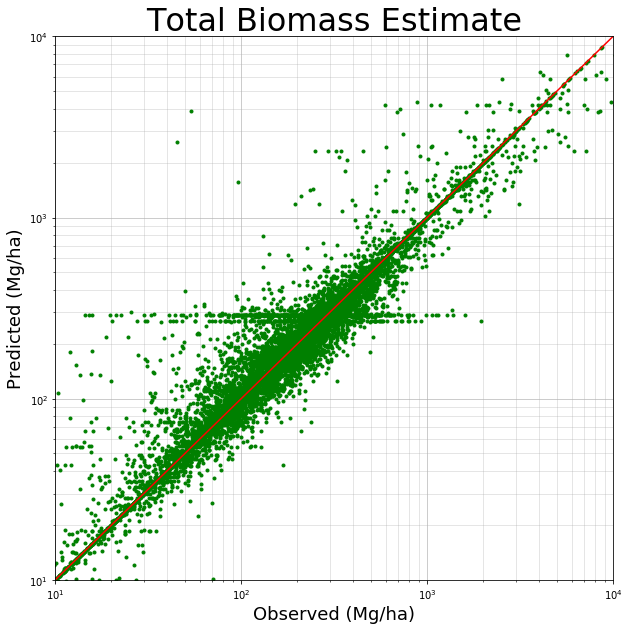

In [3]:
# Total amount of time we allow for the training
optTime = 600

# Number of CPUs to use for training and cross validation
nCPUs = 4

# What function to minimise
scoring = 'mean_squared_error'

# Number of subsamples from the Biomass Library for model training
nSubsets = 9999

# We select the tb_drymass_ha column to train on
totalBiomass = fieldBiomass[:,10]
# This is the standard error of the site level estimates
totalBiomassSE = fieldBiomass[:,11]

# Select a subsample to improve the model search speed
subSample = numpy.random.choice(len(totalBiomass),nSubsets,replace=False)
biomass=totalBiomass[subSample]
biomassSE=totalBiomassSE[subSample]
trainData=imageData[subSample]

# Use the proportion of the error in the estimates as fitting weights
biomassWeights=biomass/biomassSE

# Setup the TPOT regression options
tpot = TPOTRegressor(max_time_mins=optTime,  
                     n_jobs = nCPUs, 
                     scoring=scoring, 
                     verbosity=2, 
                     cv=10, 
                     max_eval_time_mins=1,
                     population_size=100)

# Start testing models using 10 fold cross validation and 100 models per generation
tpot.fit(trainData, biomass, sample_weight=biomassWeights)

# Export the best model to a file
tpot.export('tpot_biomass_pipeline.py')

# Build the biomass predictive model
biomassModel = tpot._fitted_pipeline.fit(imageData, totalBiomass)

# Predict the full dataset
predBiomass = biomassModel.predict(imageData)

# Print some RMSE Statistics for various ranges
print("\nTotal RMSE = %f\n" % numpy.sqrt(numpy.mean((totalBiomass-predBiomass)**2)))
stopPoints=[0,100,500,1000,2000,5000,10000]
print("Start"," Stop","Count"," RMSE")
for i in range(len(stopPoints)-1):
    idx=numpy.logical_and(totalBiomass>stopPoints[i],totalBiomass<stopPoints[i+1])
    rmse=numpy.sqrt(numpy.mean((totalBiomass[idx]-predBiomass[idx])**2))
    print('{0:5d} {1:5d} {2:5d} {3:5.0f}'.format(stopPoints[i],stopPoints[i+1],idx.sum(),rmse))



# Plot the Output in a LogLog figure
fig = plt.figure(figsize=(10,10))
plt.loglog(totalBiomass,predBiomass, 'g.',[10,10000], [10,10000],'r-')
plt.xlabel('Observed (Mg/ha)', fontsize=18)
plt.ylabel('Predicted (Mg/ha)', fontsize=18)
plt.title('Total Biomass Estimate', fontsize=32)
plt.xlim([10,10000])
plt.ylim([10,10000])
plt.grid(which='minor', alpha=0.4)                                                
plt.grid(which='major', alpha=0.8)                                                

## Predict Biomass using the RAT
Once we have the _biomassModel_ we can use that to predict the Biomass for every entry in the RAT. 

This is cool, because for Australia we only need to make around 3,000,000 predictions which is far faster than predicting every one of the 18,407,102,543 pixels in the image. That's around a __6000x__ speedup.

Here,  [RIOS](http://rioshome.org) ratapplier does the work writing a brand new attribute column into the kea file.

In [ ]:
%%time

def _ratapplier_calc_biomass(info, inputs, outputs):
    """
    Calculate Biomass from RAT.
    Called by ratapplier below
    """
    ratArray = []
    # Iterate for all the RAT columns
    for name in trainingNames:
        # Extract the array of values corresponding to the field site segments
        ratArray.append(getattr(inputs.inrat, name).astype('float'))

    # Convert the list of arrays to an array
    ratArray = numpy.transpose(numpy.array(ratArray))
    # Predict Biomass
    biomass = biomassModel.predict(ratArray)
    # Make the weird inputs nodata
    biomass[ratArray.min(axis=1) < numpy.finfo(numpy.float32).eps] = 0

    # Save to 'totalBiomass' column (will create if doesn't exist)
    setattr(outputs.outrat,"totalBiomass", biomass)


# Set up ratapplier for input / output
inFile = ratapplier.RatAssociations()
outFile = ratapplier.RatAssociations()

# Pass in clumps file for the input and output as we'll be updating the existing RAT
inFile.inrat = ratapplier.RatHandle(keaFile)
outFile.outrat = ratapplier.RatHandle(keaFile)

# Apply function to all rows in chunks
ratapplier.apply(_ratapplier_calc_biomass, inFile, outFile)
    
    

## Export the Biomass band to an individual GeoTIFF
You can run this section if you want to output just the newly calculated biomass column to a separate GeoTIFF. 

This uses one of the function from the rastergis module in [RSGISLIB](http://www.rsgislib.org/)

After this, you might like to run __gdal_translate__ to compress the output and __gdaladdo__ to add overviews for easy storage and fast viewing in your favorite GIS platform. Like this:
```
gdal_translate -a_nodata 0 -of GTIFF -co COMPRESS=DEFLATE -co ZLEVEL=9 -co TILED=YES totalBiomass.tif totalBiomassCompressed.tif

gdaladdo -r average --config TILED_OVERVIEW YES --config COMPRESS_OVERVIEW PACKBITS totalBiomassCompressed.tif 4 8 16 32 64 128 256 512

```

If everything has worked, you should have a file that looks something like this:

<img src='https://pbs.twimg.com/media/C-s2iyTUwAAxNzb.jpg' >




In [ ]:
# Additional Imports
import rsgislib
from rsgislib.rastergis import exportCol2GDALImage

# Setup the export parameters
outimage='/home/jovyan/work/Temp/totalBiomass.tif'
gdalformat = 'GTIFF'
datatype = rsgislib.TYPE_16UINT
field = 'totalBiomass'

# Run the export
exportCol2GDALImage(keaFile, outimage, gdalformat, datatype, field)